# Könnnen wir durch Topic Modelling rausfinden worüber Demokratische Kandidaten reden?

Im Grunde wollen wir ein bisschen das hier nachbauen https://www.bloomberg.com/graphics/2020-democratic-presidential-candidate-policies/

Agenda:

- Topic Modeling als Inspiration für Themen
- Themen anhand von Keywords anlegen
- Steamgraphs machen


In [49]:
import pandas as pd
pd.set_option("display.max_columns", 60)
pd.set_option("display.max_colwidth", 300)

# Topic Modeling

Ich habe 39 Tausend Tweets aus Twitter Accounts folgender Demokraten heruntergeladen.  Ich habe [GetOldTweets3](https://github.com/Mottl/GetOldTweets3/) benutzt, aktuell scheint es Probleme zu machen, deswegen verwenden wir meine alten Daten.

In [50]:
usernames = [
    'joebiden', 'corybooker','petebuttigieg','juliancastro','kamalaharris',
    'amyklobuchar','betoorourke','berniesanders','ewarren','andrewyang',
    'michaelbennet','governorbullock','billdeblasio','johndelaney',
    'tulsigabbard','waynemessam','timryan','joesestak','tomsteyer',
    'marwilliamson','sengillibrand','hickenlooper','jayinslee',
    'sethmoulton','ericswalwell'
]

# Schauen wir mal rein

In [5]:
# We don't need all of the columns, let's leave out a lot of them
columns = ['username', 'text', 'date']

df = pd.read_csv("data/tweets.csv", usecols=columns)
df.sample(5)

,username,text,date
27208,CoryBooker,This should be interesting ....,2019-01-27 12:55:44+00:00
19112,JayInslee,"I said it at the march, and I’ll say it here, too. Let’s go build a clean energy future. Let’s go get ‘em.",2019-05-09 20:17:52+00:00
26981,CoryBooker,100% - we won’t give up the fight until expanded background checks becomes law. Grateful to my friend @ChrisMurphyCT for introducing this.,2019-03-20 22:57:05+00:00
26490,CoryBooker,"I’m about to take the stage at the Iowa Hall of Fame celebration to talk about how we can unite to build a fairer, more just country. Watch live here: https://coryb.kr/iowahalloffame",2019-06-09 19:21:01+00:00
28140,MichaelBennet,"In order for us to leave a better country for our kids and grandkids, we need a much better politics than we have now. We can’t accept politicians who are destroying the institutions that generations before us worked so hard to preserve.",2019-03-02 16:47:46+00:00


Wie viele haben wir genau?

In [6]:
df.shape

(38559, 3)

Wie viele von jedem Kandidaten?

In [7]:
df.username.value_counts()

AndrewYang         4425
marwilliamson      2571
ewarren            2570
JayInslee          2120
KamalaHarris       2110
JohnDelaney        1913
BernieSanders      1881
GovernorBullock    1721
ericswalwell       1705
BetoORourke        1667
SenGillibrand      1538
TimRyan            1481
amyklobuchar       1405
CoryBooker         1315
TomSteyer          1279
sethmoulton        1239
JulianCastro       1220
Hickenlooper        959
MichaelBennet       904
TulsiGabbard        893
PeteButtigieg       856
JoeBiden            856
WayneMessam         815
JoeSestak           619
BilldeBlasio        497
Name: username, dtype: int64

## Topic Modelling

Wir werden versuchen, mithilfe des **Topic Modeling** eine Liste von Themen zu erstellen, um die es in jedem Tweet geht, sowie Wörter, die mit jedem Thema verknüpft sind. Warum machen wir das? Weil es eine Anwendung der Methoden ist die wir gerade kennengelernt haben :) 

Zuerst müssen wir unseren Text in Zahlen **vektorisieren**, die Scikit-Learn verstehen kann, und dann verwenden wir die Topic Modellierung, um die darin enthaltenen Themen zu finden.

### Vektorisierung des Textes

Wenn man eine Themenmodellierung durchführt, hängt die Art der Vektorisierung, die man verwendent, von der Art des Themenmodells ab, das man erstellen möchte. Für die Verwendung eines LDA-Themenmodells ist ein CountVectorizer erforderlich. 

Für jede andere Art von Themenmodell funktioniert am besten mit einem `TfidfVectorizer`. In LDA ist TF-IDF auf magische Weise integriert, sodass es den Unterschied zwischen niederfrequenten und hochfrequenten Wörtern versteht.

Ich bin faul und es dauert lange, bis LDA ausgeführt wird - ausserdem ist es etwas komplizert. Daher werden wir LDA nicht verwenden, was bedeutet, dass wir einen `TfidfVectorizer` benötigen. 

Da ich Wörter wie "Tomate" und "Tomaten" und "Tomaten" kombiniert haben möchte, werde ich auch einen Stemmer verwenden. 

In [51]:
#!pip install pystemmer

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
import Stemmer

# Using pyStemmer because it's way faster than NLTK
stemmer = Stemmer.Stemmer('en')

# Based on TfidfVectorizer
# Das hier müsst ihr nicht nachvollziehen können, im grunde bauen wir uns dadurch unseren eigenen Vectorizer
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords([w for w in analyzer(doc)])

Wir werden alle Wörter zählen, die mindestens einhundert Mal auftauchen. Wenn es in 40.000 Tweets nicht hundertmal erwähnt wird, ist das Wort wahrscheinlich nicht so wichtig.

In [54]:
%%time
vectorizer = StemmedTfidfVectorizer(stop_words='english',
                                    min_df=100)

matrix = vectorizer.fit_transform(df.text.str.replace("[^\w ]", ""))

CPU times: user 2.1 s, sys: 28.7 ms, total: 2.12 s
Wall time: 2.13 s


In [12]:
matrix.shape # hier drin sind nur noch zahlen für jedes wort eine eindeutige zahl

(38559, 975)

Wir haben nun die Wörter bis auf knapp tausend reduziert. Jetzt, da wir vektorisiert sind, können wir mit der Themenmodellierung fortfahren.
Jetzt, da wir vektorisiert sind, können wir mit der Themenmodellierung fortfahren.

###  LSI for topic modeling

Wann immer wir ein Themenmodell erstellen, haben wir die wichtige Frage: **Wie viele Themen?** Zu wenige ist es zu grob, zu viele ist es zu kleinteilig, es erfordert einiges an ausprobieren. Ich fand 17 nicht schlecht. 

In [12]:
%%time
from sklearn.decomposition import NMF

# Tell the model to find the topics
model = NMF(n_components=17)
model.fit(matrix)

# Print the top 10 words per category
n_words = 10
feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(model.components_):
    message = "Topic #%d: " % topic_idx
    message += ", ".join([feature_names[i]
                         for i in topic.argsort()[:-n_words - 1:-1]])
    print(message)
print()

Topic #0: thank, have, leadership, appreci, come, soon, host, share, amaz, convers
Topic #1: work, famili, worker, pay, american, year, countri, job, economi, america
Topic #2: im, join, live, campaign, tune, run, talk, fight, tonight, iowa
Topic #3: trump, presid, donald, administr, immigr, mr, run, elect, state, unit
Topic #4: climat, chang, crisi, defeat, plan, threat, ourclimatemo, action, issu, big
Topic #5: right, fight, women, vote, protect, stand, human, reproduct, equal, abort
Topic #6: gun, violenc, end, epidem, communiti, live, action, safeti, nra, check
Topic #7: great, iowa, meet, day, talk, morn, today, enjoy, state, convers
Topic #8: care, health, afford, plan, medicar, access, mental, insur, univers, million
Topic #9: make, let, debat, sure, help, just, stage, happen, donat, donor
Topic #10: peopl, american, power, polit, govern, campaign, money, want, young, dont
Topic #11: need, dont, help, countri, real, donor, that, america, talk, secur
Topic #12: love, happi, day, 

Diese sehen tatsächlich ganz gut  aus - Wertschätzung, Arbeit und Familie, Klimawandel, "reproductive rights", Iowa, Waffengewalt, Gesundheitswesen, Spender und politische Macht und vielleicht ein bisschen Green New Deal.

## Themenmodelle als Inspiration

Nachdem wir unsere Themenmodelle haben, lautet die große Frage: **Was machen wir mit ihnen?** Normalerweise verwenden wir Themenmodelle, um Dingen automatisch Kategorien zuzuweisen - "Hier geht es um das Gesundheitswesen", "Hier geht es um Waffengewalt". "etc - aber hier sieht es etwas anders aus.

Wir können nun **Schlüsselwörter** nutzen, um jedem Tweet eine Kategorie (oder Kategorien) zuzuweisen. Statt jetzt automatisch mit Topic modeling dem Tweet eine Kategorie zuzuweisen, lassen wir uns stattdessen nur durch die gefundenen Topic inspirieren und nutzen unsere eigenen Keywords. Das funktioniert für kleine Tweets besser als Topic Modeling - das funktioniert gut bei längeren Texten. 

# Topics mit Keywords selbst machen

Wir erstellen eine kurze Liste von Wörtern , die mit dem Thema verbunden sind. Unser Ansatz wird etwas umständlich sein, aber er ist ziemlich flexibel für Dinge, die wir in Zukunft vielleicht tun möchten.

In [16]:
# We're only using single words (no "green new deal") because the
# stemmer won't work with multiple words

categories = {
    'immigration': ['immigration', 'border', 'wall'],
    'education': ['students', 'education', 'teacher'],
    'foreign_policy': ['foreign policy', 'peace'],
    'climate_change': ['climate', 'emissions', 'carbon'],
    'economy': ['economy', 'tariffs', 'taxes'],
    'military': ['veterans', 'troops', 'war'],
    'jobs': ['jobs', 'unemployment', 'wages'],
    'drugs': ['drugs', 'opioid'],
    'health': ['health', 'insurance', 'medicare'],
    'repro_rights': ['reproductive', 'abortion'],
    'gun_control': ['gun'],
}
categories

{'immigration': ['immigration', 'border', 'wall'],
 'education': ['students', 'education', 'teacher'],
 'foreign_policy': ['foreign policy', 'peace'],
 'climate_change': ['climate', 'emissions', 'carbon'],
 'economy': ['economy', 'tariffs', 'taxes'],
 'military': ['veterans', 'troops', 'war'],
 'jobs': ['jobs', 'unemployment', 'wages'],
 'drugs': ['drugs', 'opioid'],
 'health': ['health', 'insurance', 'medicare'],
 'repro_rights': ['reproductive', 'abortion'],
 'gun_control': ['gun']}

Wir werden diese in einen schönen langen Dataframe aus Wörtern und Kategorienamen verwandeln. 
Wir werden auch die Keywords stemmen, damit sie etwas breiter übereinstimmen: `immigrant`, `immigrants`, and `immigration` sollten alle als  `immigr` gestemmt werden.

In [18]:
import Stemmer

stemmer = Stemmer.Stemmer('en')

dfs = []
for key,values in categories.items():
    words = pd.DataFrame({'category': key, 'term': stemmer.stemWords(values)})
    dfs.append(words)

terms_df = pd.concat(dfs)

terms_df

,category,term
0,immigration,immigr
1,immigration,border
2,immigration,wall
0,education,student
1,education,educ
2,education,teacher
0,foreign_policy,foreign polici
1,foreign_policy,peac
0,climate_change,climat
1,climate_change,emiss


## Custom Vectorizer

Jetzt werden wir unseren eignen Vektorisierer machen: **Wir werden nur Wörter in unserer Liste zählen** und wir werden nur Ja / Nein (1/0) dh. existiert bzw. existiert nicht für jedes der Wörter aufschreiben.

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
import Stemmer

# Using pyStemmer because it's way faster than NLTK
stemmer = Stemmer.Stemmer('en')

# Based on CountVectorizer
# Auch hier wieder nicht relevant warum wir das so komisch machen
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords([w for w in analyzer(doc)])

In [58]:
# Take the 'term' column from our list of terms
term_list = list(terms_df.term)

# binary=True macht nur 0/1
# vocabulary= das Vokabular das wir tracken wollen
vectorizer = StemmedCountVectorizer(binary=True, vocabulary=term_list)
matrix = vectorizer.fit_transform(df.text)
words_df = pd.DataFrame(matrix.toarray(),columns=vectorizer.get_feature_names())
words_df.head()

,immigr,border,wall,student,educ,teacher,foreign polici,peac,climat,emiss,carbon,economi,tariff,tax,veteran,troop,war,job,unemploy,wage,drug,opioid,health,insur,medicar,reproduct,abort,gun
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Von den ersten fünf Tweets scheint nur der vierte in eine Kategorie zu passen - er enthält das Wort **teacher**, also werden wir es in die Bildungskategorie (education) aufnehmen.

Wir werden jede Kategorie durchlaufen und dann prüfen, ob einer der Begriffe für diese Kategorie eine "1" enthält. In diesem Fall weisen wir dieser Zeile eine "1" für die Kategorie zu. Wenn nicht, geben wir eine 0.

Zum Beispiel hat Zeile 3 nicht "students" oder "education", sondern "teacher". Als Ergebnis erhält es eine "1" für die Bildungskategorie.

In [59]:
# Group the terms by category, then loop through each category
for category_name, rows in terms_df.groupby('category'):
    # Wandle die begriffe für eine Kategorie in eine einfache liste um z.B. ['student', 'educ', 'teacher']
    terms = list(rows['term'])
    print(f"Looking at {category_name} with terms {terms}")

    # words_df[terms] holt alle columns für 'student', 'educ', und 'teacher'
    # .any(axis=1) schaut ob eine davon eine 1 ist , weisst dann True/False zu
    # .astype(int) wandelt True/False in 1/0 um
    # df[category_name] = weist dann den wert df['education'] zu
    df[category_name] = words_df[terms].any(axis=1).astype(int)

Looking at climate_change with terms ['climat', 'emiss', 'carbon']
Looking at drugs with terms ['drug', 'opioid']
Looking at economy with terms ['economi', 'tariff', 'tax']
Looking at education with terms ['student', 'educ', 'teacher']
Looking at foreign_policy with terms ['foreign polici', 'peac']
Looking at gun_control with terms ['gun']
Looking at health with terms ['health', 'insur', 'medicar']
Looking at immigration with terms ['immigr', 'border', 'wall']
Looking at jobs with terms ['job', 'unemploy', 'wage']
Looking at military with terms ['veteran', 'troop', 'war']
Looking at repro_rights with terms ['reproduct', 'abort']


In [60]:
df.head(4)

,username,text,date,climate_change,drugs,economy,education,foreign_policy,gun_control,health,immigration,jobs,military,repro_rights
0,KamalaHarris,Keeping the Midland and Odessa community and the victims in my thoughts and prayers. Grateful to first responders who ran into harm's way. I’m sick of this. America is sick of this. We need to act.,2019-08-31 23:22:40+00:00,0,0,0,0,0,0,0,0,0,0,0
1,KamalaHarris,"Today is the last day to give before our critical August fundraising deadline. Together, we’re building something special — and every dollar makes a difference to reaching more voters across the country. Chip in now.",2019-08-31 21:35:00+00:00,0,0,0,0,0,0,0,0,0,0,0
2,KamalaHarris,Brazil's President Bolsonaro’s fanning the flames of the Amazon fires and weakening of regulations protecting Indigenous lands has put people there in harm’s way.,2019-08-31 19:34:00+00:00,0,0,0,0,0,0,0,0,0,0,0
3,KamalaHarris,Investing in our nation’s teachers shouldn’t be an afterthought.,2019-08-31 17:42:00+00:00,0,0,0,1,0,0,0,0,0,0,0


## Nach Person gruppieren

Nachdem wir nun eine Reihe von Tweets haben, die mit verschiedenen Kategorien gekennzeichnet sind, können wir beginnen, sie zu zählen und zu klassifizieren. Zum Beispiel können wir sehen, wer am meisten über Jobs twittert. 

In [25]:
df.groupby('username').jobs.sum().sort_values(ascending=False)

username
BernieSanders      218
AndrewYang         132
ewarren            122
JohnDelaney        118
JayInslee          113
KamalaHarris       113
TimRyan             82
GovernorBullock     75
BetoORourke         63
Hickenlooper        60
marwilliamson       59
SenGillibrand       52
CoryBooker          51
WayneMessam         41
JoeBiden            41
TomSteyer           40
amyklobuchar        39
sethmoulton         38
BilldeBlasio        31
JulianCastro        30
PeteButtigieg       29
TulsiGabbard        27
MichaelBennet       26
ericswalwell        19
JoeSestak           15
Name: jobs, dtype: int64

# Nach allen Themen gruppieren

Da diese 0 und 1 unsere einzigen numerischen Spalten sind, können wir den Dataframe einfach auffordern, nach Benutzernamen zu gruppieren und jede Kategorie zu addieren.

In [61]:
overall = df.groupby('username').sum()
overall

,climate_change,drugs,economy,education,foreign_policy,gun_control,health,immigration,jobs,military,repro_rights
username,,,,,,,,,,,
AndrewYang,41,20,142,65,2,21,51,27,132,38,5
BernieSanders,87,72,111,146,16,38,321,123,218,73,36
BetoORourke,86,23,57,146,9,83,126,165,63,94,24
BilldeBlasio,10,1,18,13,1,11,29,14,31,8,4
CoryBooker,18,37,26,39,4,108,62,49,51,33,33
GovernorBullock,62,19,59,63,2,30,34,32,75,32,3
Hickenlooper,46,9,70,20,7,72,43,24,60,23,15
JayInslee,747,4,121,53,3,41,64,52,113,28,53
JoeBiden,40,7,48,48,16,37,72,37,41,20,0


Das Problem mit dieser Ansicht ist, dass einige Kandidaten viel twittern und einige Kandidaten viel weniger. Wenn wir es grafisch darstellen, gibt es keinen guten Überblick darüber, welche Themen die Kampagnen der Kandidaten wertschätzen.

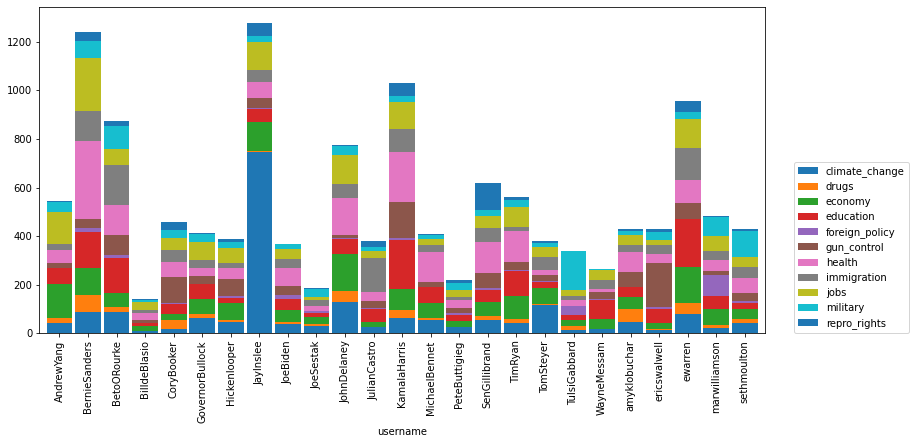

In [27]:
ax = overall.plot(kind='bar', stacked=True, figsize=(13,6), width=0.9)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

Was wir brauchen ist eine Ansicht, die auf Prozentsätzen basiert. Dazu müssen wir jede Spalte durch die Summe der Zählungen in dieser Spalte teilen. Wegen "Pandas-Logik" müssen wir ".div" anstelle von "/" verwenden. Das Teilungszeichen gibt euch möglicherweise keinen Fehler, aber es gibt definitiv falsche Ergebnisse!

In [28]:
overall_pct = overall.div(overall.sum(axis=1), axis=0)
overall_pct

,climate_change,drugs,economy,education,foreign_policy,gun_control,health,immigration,jobs,military,repro_rights
username,,,,,,,,,,,
AndrewYang,0.075368,0.036765,0.261029,0.119485,0.003676,0.038603,0.093750,0.049632,0.242647,0.069853,0.009191
BernieSanders,0.070105,0.058018,0.089444,0.117647,0.012893,0.030620,0.258662,0.099114,0.175665,0.058824,0.029009
BetoORourke,0.098174,0.026256,0.065068,0.166667,0.010274,0.094749,0.143836,0.188356,0.071918,0.107306,0.027397
BilldeBlasio,0.071429,0.007143,0.128571,0.092857,0.007143,0.078571,0.207143,0.100000,0.221429,0.057143,0.028571
CoryBooker,0.039130,0.080435,0.056522,0.084783,0.008696,0.234783,0.134783,0.106522,0.110870,0.071739,0.071739
GovernorBullock,0.150852,0.046229,0.143552,0.153285,0.004866,0.072993,0.082725,0.077859,0.182482,0.077859,0.007299
Hickenlooper,0.118252,0.023136,0.179949,0.051414,0.017995,0.185090,0.110540,0.061697,0.154242,0.059126,0.038560
JayInslee,0.584050,0.003127,0.094605,0.041439,0.002346,0.032056,0.050039,0.040657,0.088350,0.021892,0.041439
JoeBiden,0.109290,0.019126,0.131148,0.131148,0.043716,0.101093,0.196721,0.101093,0.112022,0.054645,0.000000


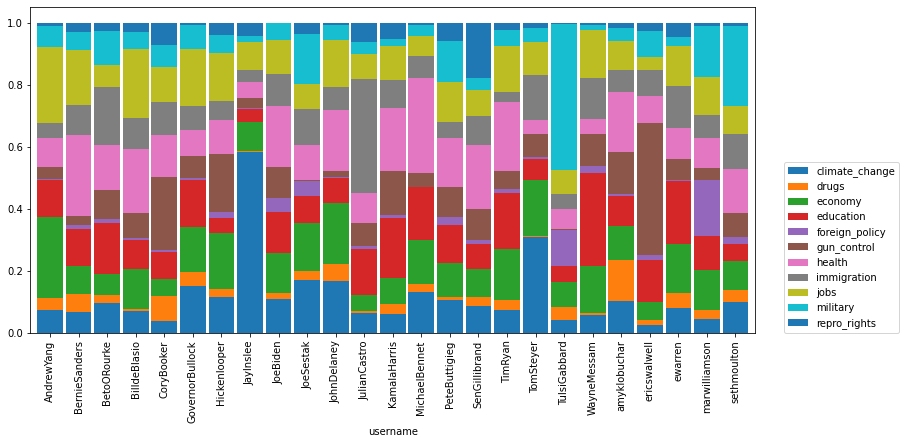

In [29]:
ax = overall_pct.plot(kind='bar', stacked=True, figsize=(13,6), width=0.9)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

# Mit Plotly visualisieren
Matplotlib sieht oft ewas hässlich aus. Lasst uns lieber plotly nehmen, das ist schön interaktiv. 
Wir müssen dafür den Dataframe etwas re-shapen.

In [62]:
reshaped = overall_pct.reset_index().melt(id_vars=['username'], var_name='topic', value_name='pct')
reshaped.head()

,username,topic,pct
0,AndrewYang,climate_change,0.075368
1,BernieSanders,climate_change,0.070105
2,BetoORourke,climate_change,0.098174
3,BilldeBlasio,climate_change,0.071429
4,CoryBooker,climate_change,0.039130


In [63]:
import plotly.express as px

fig = px.bar(reshaped, x='username', y='pct', color='topic')
fig.show()

# Steamgraphs machen

Streamgraphs sind eine Visualisierungstechnik, die nicht allzu oft verwendet wird, aber ich glaube die Leute mögen sie. Es ist eine Art gestapeltes Flächendiagramm, das vertikal zentriert ist und eine Handvoll Vor- und Nachteile enthält. 

Wir müssen zunächst das Datum typcasten.

In [33]:
# Convert the date to a datetime, then pull out the week
df['date'] = pd.to_datetime(df.date)
df.head(2)

,username,text,date,climate_change,drugs,economy,education,foreign_policy,gun_control,health,immigration,jobs,military,repro_rights
0,KamalaHarris,Keeping the Midland and Odessa community and the victims in my thoughts and prayers. Grateful to first responders who ran into harm's way. I’m sick of this. America is sick of this. We need to act.,2019-08-31 23:22:40+00:00,0,0,0,0,0,0,0,0,0,0,0
1,KamalaHarris,"Today is the last day to give before our critical August fundraising deadline. Together, we’re building something special — and every dollar makes a difference to reaching more voters across the country. Chip in now.",2019-08-31 21:35:00+00:00,0,0,0,0,0,0,0,0,0,0,0


In [34]:
df.dtypes

username                       object
text                           object
date              datetime64[ns, UTC]
climate_change                  int64
drugs                           int64
economy                         int64
education                       int64
foreign_policy                  int64
gun_control                     int64
health                          int64
immigration                     int64
jobs                            int64
military                        int64
repro_rights                    int64
dtype: object

## Resampling

Wir sehen jetzt, dass es ein datetime64 [ns, UTC] ist, was bedeutet, dass wir Dinge tun können, wie den Tag des Jahres oder den Monat oder die Woche herauszuholen! Wir wollen unsere Daten jedoch nach jeder Woche gruppieren.

Das Gruppieren nach Zeit heisst resampling auf und ist recht einfach. Wir werden die Tweets von Kamala Harris herausziehen und sie dann anhand der Datumsspalte in 8-Tage-Chunks resamplen.

In [64]:
# Resample and make it sum every 7 days
harris = df[df.username == 'KamalaHarris'].resample('8D', on='date').sum()
harris.head()

,climate_change,drugs,economy,education,foreign_policy,gun_control,health,immigration,jobs,military,repro_rights
date,,,,,,,,,,,
2019-01-01 00:00:00+00:00,3,1,5,2,0,1,6,4,5,0,0
2019-01-09 00:00:00+00:00,1,4,1,4,0,2,6,3,2,1,0
2019-01-17 00:00:00+00:00,1,0,1,7,0,1,5,7,7,0,1
2019-01-25 00:00:00+00:00,2,1,6,5,0,4,9,5,5,0,1
2019-02-02 00:00:00+00:00,2,3,5,4,1,3,5,6,3,1,2


Als Grafik

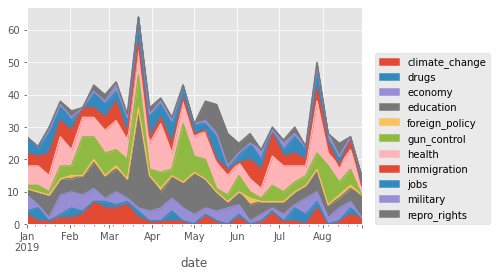

In [65]:
ax = harris.plot(kind='area', stacked=True)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

## Steamgraphs mit Matplotlib

So wie bekommen wir Steamgraphs hin, gottseidank hat Matplotlib ein Beispiel

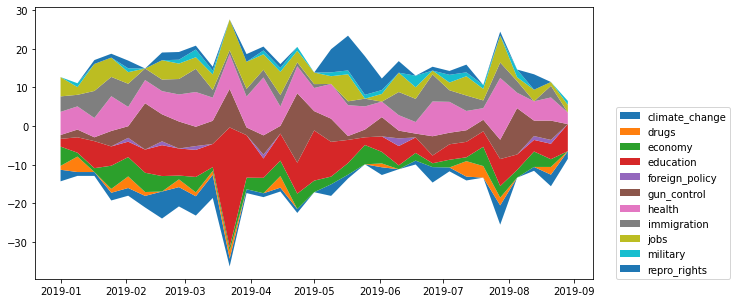

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))

# Plot a stackplot - https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/stackplot_demo.html
ax.stackplot(harris.index, harris.T, baseline='wiggle', labels=harris.columns)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

Sieht ok aus aber so zackig. Wir können nicht einfach sagen: "Zeichne glatte Linien!" Matplotlib benötigt echte Daten. Es ist sehr zackig, weil die Daten derzeit nur alle acht Tage vorliegen und jedees Mal ein sehr scharfer Sprung zum nächsten sein kann.

### Glätten mit Pandas

Wir tun so, als hätten wir alle zwei Tage Daten.  Zuerst machen wir eine Liste aller Tage, die wir existieren wollen.

In [41]:
# Make a list of dates between the first and last 
first = harris.index.min()
last = harris.index.max()

# Go between the first and the last in 2-day chunks
frequency = pd.date_range(start=first, end=last, freq='2D')
frequency[:10]

DatetimeIndex(['2019-01-01 00:00:00+00:00', '2019-01-03 00:00:00+00:00',
               '2019-01-05 00:00:00+00:00', '2019-01-07 00:00:00+00:00',
               '2019-01-09 00:00:00+00:00', '2019-01-11 00:00:00+00:00',
               '2019-01-13 00:00:00+00:00', '2019-01-15 00:00:00+00:00',
               '2019-01-17 00:00:00+00:00', '2019-01-19 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='2D')

Jetzt werden wir sie unserem Dataframe hinzufügen. Die Daten werden fehlen, wenn wir die neuen Zeilen hinzufügen, da Pandas sicher sein kann was dort hin soll.

In [42]:
# Reindex our dataframe, adding a bunch of new days, but missing data!
smooth = harris.reindex(frequency)
smooth.head(6)

,climate_change,drugs,economy,education,foreign_policy,gun_control,health,immigration,jobs,military,repro_rights
2019-01-01 00:00:00+00:00,3.0,1.0,5.0,2.0,0.0,1.0,6.0,4.0,5.0,0.0,0.0
2019-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-09 00:00:00+00:00,1.0,4.0,1.0,4.0,0.0,2.0,6.0,3.0,2.0,1.0,0.0
2019-01-11 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Füllen wir diese Daten durch Interpolation aus. Wir werden Pandas sagen, dass er eine quadratische Interpolation verwenden soll, um es schön und glatt zu machen.

In [43]:
# Plan out 2-day chunks between the first and last days
first = harris.index.min()
last = harris.index.max()
frequency = pd.date_range(start=first, end=last, freq='2D')

# Inject the new (empty) rows, then interpolate new data
smoothed = harris.reindex(frequency).interpolate(method='quadratic')
smoothed.head()

,climate_change,drugs,economy,education,foreign_policy,gun_control,health,immigration,jobs,military,repro_rights
2019-01-01 00:00:00+00:00,3.000000,1.000000,5.000000,2.000000,0.000000,1.000000,6.000000,4.000000,5.000000,0.000000,0.000000
2019-01-03 00:00:00+00:00,2.302575,2.607579,3.674880,2.294317,-0.004572,1.564950,6.232804,3.075563,3.237994,0.484092,-0.133987
2019-01-05 00:00:00+00:00,1.736766,3.643438,2.566507,2.725757,-0.006097,1.919933,6.310405,2.600751,2.150659,0.812123,-0.178649
2019-01-07 00:00:00+00:00,1.302575,4.107579,1.674880,3.294317,-0.004572,2.064950,6.232804,2.575563,1.737994,0.984092,-0.133987
2019-01-09 00:00:00+00:00,1.000000,4.000000,1.000000,4.000000,0.000000,2.000000,6.000000,3.000000,2.000000,1.000000,0.000000


# Das Finale
So jetzt probieren wir es nochmal

Text(0.5, 1.0, 'Kamala Harris twitter topics')

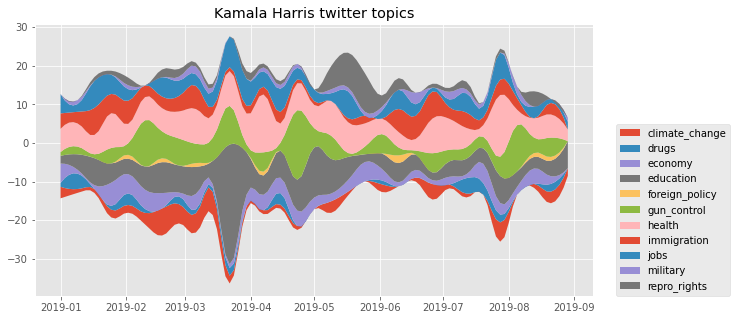

In [47]:
fig, ax = plt.subplots(figsize=(10,5))

# Plot a stackplot - https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/stackplot_demo.html
ax.stackplot(smoothed.index, smoothed.T,
             baseline='wiggle', labels=smoothed.columns)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

# Set the title
ax.set_title("Kamala Harris twitter topics")

In hübsch

In [46]:
plt.style.use('ggplot')